In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Dict
from textblob import TextBlob
import nltk

nltk.download("wordnet")
nltk.download("brown")
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /home/jovyan/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Unzip Data

In [2]:
!unzip ./modcloth_data.json.zip
!unzip ./renttherunway_data_1.json.zip
!unzip ./renttherunway_data_2.json.zip

Archive:  ./modcloth_data.json.zip
  inflating: modcloth_data.json      
  inflating: __MACOSX/._modcloth_data.json  
Archive:  ./renttherunway_data_1.json.zip
  inflating: renttherunway_data_1.json  
  inflating: __MACOSX/._renttherunway_data_1.json  
Archive:  ./renttherunway_data_2.json.zip
  inflating: renttherunway_data_2.json  


In [2]:
RUNTHERUNWAY_1_FILE_PATH = Path('./renttherunway_data_1.json')
RUNTHERUNWAY_2_FILE_PATH = Path('./renttherunway_data_2.json')
MODCLOTH_FILE_PATH = Path('./modcloth_data.json')

# Load Runtherunway

In [3]:
runtherunway = {'data': {}, 'features': set()}
with open(RUNTHERUNWAY_1_FILE_PATH, 'r') as infile:
    for line in infile:
        review = json.loads(line)
        item_id = review['item_id']
        if item_id in runtherunway['data']:
            runtherunway['data'][item_id].append(review)
        else:
            runtherunway['data'][item_id] = [review]

        for key in review.keys():
            runtherunway['features'].add(key)

with open(RUNTHERUNWAY_2_FILE_PATH, 'r') as infile:
    for line in infile:
        review = json.loads(line)
        item_id = review['item_id']
        if item_id in runtherunway['data']:
            runtherunway['data'][item_id].append(review)
        else:
            runtherunway['data'][item_id] = [review]

        for key in review.keys():
            runtherunway['features'].add(key)

# Load Modcloth

In [4]:
modcloth = {'data': {}, 'features': set()}
with open(MODCLOTH_FILE_PATH, 'r') as infile:
    for row in infile:
        review = json.loads(row)
        item_id = review['item_id']
        if item_id in modcloth['data']:
            modcloth['data'][item_id].append(review)
        else:
            modcloth['data'][item_id] = [review]

        for key in review.keys():
            modcloth['features'].add(key)

# Data Features

In [5]:
common_features = runtherunway['features'].intersection(modcloth['features'])
print(f"runtherunway_features = {runtherunway['features']} {len(runtherunway['features'])}\n")
print(f"modcloth_features = {modcloth['features']} {len(modcloth['features'])}\n")
print(f"common_features = {common_features} {len(common_features)}")

runtherunway_features = {'category', 'fit', 'rented for', 'review_text', 'height', 'size', 'age', 'body type', 'review_date', 'item_id', 'rating', 'review_summary', 'bust size', 'user_id', 'weight'} 15

modcloth_features = {'category', 'hips', 'shoe size', 'size', 'bra size', 'user_name', 'height', 'quality', 'fit', 'shoe width', 'bust', 'waist', 'length', 'item_id', 'review_summary', 'review_text', 'cup size', 'user_id'} 18

common_features = {'category', 'fit', 'size', 'height', 'item_id', 'review_summary', 'review_text', 'user_id'} 8


# Data Count - Items and Reviews

In [6]:
def get_reviews_count(data):
    count = 0
    for item_id, reviews in data.items():
        count += len(reviews)
    return count
        
modcloth_items_count = len(modcloth['data'].keys())
runtherunway_items_count = len(runtherunway['data'].keys())
total_items_count = modcloth_items_count + runtherunway_items_count
print(f'total items = {runtherunway_items_count} + {modcloth_items_count} = {total_items_count}')

runtherunway_reviews_count = get_reviews_count(runtherunway['data'])
modcloth_reviews_count = get_reviews_count(modcloth['data'])
total_reviews_count = runtherunway_reviews_count + modcloth_reviews_count
print(f'total reviews = {runtherunway_reviews_count} + {modcloth_reviews_count} = {total_reviews_count}')

total items = 5850 + 1378 = 7228
total reviews = 192544 + 82790 = 275334


# Total Data

- Only keep reviews that have common_features from both modcloth and runtherunway clothing fit data.

- Data schema is - Dict[str, List[Dict]] 

- Ex - {'ItemId_1': [{'review_text': '..', 'height': '..', ..., 'category': '..'}, ...], 'ItemId_2': [{..}, ...], ...}

In [7]:
def data_contains_features(data, features):
    data_features = data.keys()
    for f in features:
        if f not in data_features:
            return False
    return True

total_data = {}
for item_id, reviews in modcloth['data'].items():
    if item_id not in total_data:
        total_data[item_id] = []
    
    for review in reviews:
        if data_contains_features(review, common_features):
            total_data[item_id].append(review)

for item_id, reviews in runtherunway['data'].items():
    if item_id not in total_data:
        total_data[item_id] = []
    
    for review in reviews:
        if data_contains_features(review, common_features):
            total_data[item_id].append(review)


total_items_count = len(total_data)
total_reviews_count = get_reviews_count(total_data)

print('TOTAL')
print(f'Number of items = {total_items_count}')
print(f'Number of reviews = {total_reviews_count}')

TOTAL
Number of items = 7225
Number of reviews = 266929


# Train and Test Data

In [9]:
train_items_percent = 0.7
train_items_count = int(total_items_count * train_items_percent)

# Get train and test items
total_items = list(total_data.keys())
train_items = total_items[:train_items_count]
test_items = total_items[train_items_count:]

# Curate train and test data
train_data = {item: total_data[item] for item in train_items}
test_data = {item: total_data[item] for item in test_items}

print('TRAIN')
print(f'Number of items = {len(train_items)}')
print(f'Number of reviews = {get_reviews_count(train_data)}')

print('')

print('TEST')
print(f'Number of items = {len(test_items)}')
print(f'Number of reviews = {get_reviews_count(test_data)}')

TRAIN
Number of items = 5057
Number of reviews = 251578

TEST
Number of items = 2168
Number of reviews = 15351


# Types of 'fit' (Classifications)

In [10]:
labels = set()
for review_list in train_data.values():
    for review in review_list:
        labels.add(review['fit'])

print(labels, len(labels))

{'fit', 'small', 'large'} 3


# Class Distributions

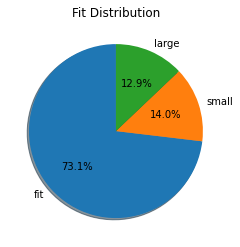

In [11]:
labels_count = {l: 0 for l in labels}

for review_list in train_data.values():
    for review in review_list:
        labels_count[review['fit']] += 1 

for label in labels_count.keys():
    labels_count[label] = int((labels_count[label] / total_reviews_count) * 100)

labels = labels_count.keys()
sizes = labels_count.values()

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Fit Distribution')
plt.show()

# Does user's 'height' influence 'fit'?

- Analyze entire train data and consider fit, small and large fits.

In [23]:
def get_height_in_meters(height_str):
    if 'ft' in height_str:
        feet = int(height_str[0])
        inches = int(height_str[-3])
    else:
        feet = int(height_str[0])
        inches = int(height_str[-2])
    height = feet * 0.3048 + inches * 0.0254
    return round(height, 2)

def get_height_data(data, fit='*'):
    heights_count = {}
    all_heights = []

    for review_list in train_data.values():
        for review in review_list:
            if fit == '*' or review['fit'] == fit:
                if 'height' in review:
                    height = get_height_in_meters(review['height'])
                    heights_count[height] = heights_count.get(height, 0) + 1
                    all_heights.append(height)

    return all_heights, heights_count
  
def plot_height_data(fit, title):
    all_heights, heights_count = get_height_data(train_data, fit)    
    heights = [h for h in sorted(heights_count)]
    counts = [heights_count[h] for h in heights]
    height_mean = round(np.mean(all_heights), 2)
    height_variance = round(np.var(all_heights), 2)

    fig, ax = plt.subplots()
    ax.plot(heights, counts)
    plt.title(title)
    plt.xlabel('User Height (m)')
    plt.ylabel('Count')
    note = '\n'.join((f'mean = {height_mean} m', f'var = {height_variance} m', f'count = {sum(counts)}'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
    ax.text(0.05, 0.95, note, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.show()

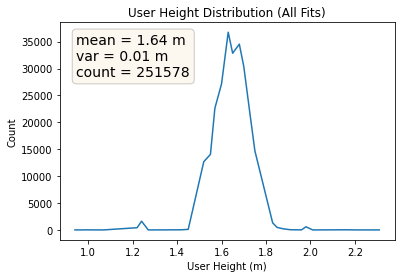

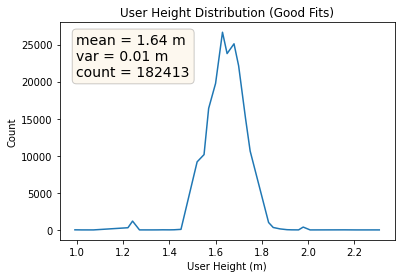

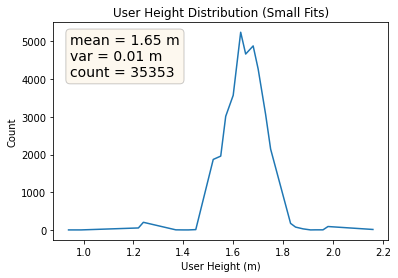

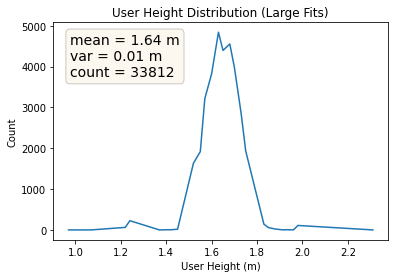

In [24]:
plot_height_data(fit='*', title='User Height Distribution (All Fits)')
plot_height_data(fit='fit', title='User Height Distribution (Good Fits)')
plot_height_data(fit='small', title='User Height Distribution (Small Fits)')
plot_height_data(fit='large', title='User Height Distribution (Large Fits)')

# Does item's 'size' influence 'fit'?

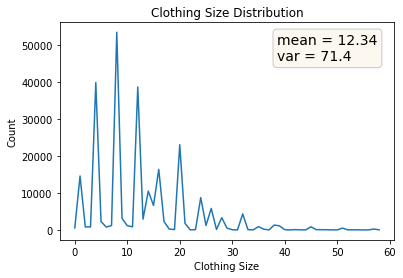

In [23]:
sizes_count = {}
all_sizes = []

for review_list in train_data.values():
    for review in review_list:
        if 'size' in review:
            size = review['size']
            sizes_count[size] = sizes_count.get(size, 0) + 1
            all_sizes.append(size)

sizes = [h for h in sorted(sizes_count)]
counts = [sizes_count[s] for s in sizes]
size_mean = round(np.mean(all_sizes), 2)
size_variance = round(np.var(all_sizes), 2)

fig, ax = plt.subplots()
ax.plot(sizes, counts)
plt.title('Clothing Size Distribution')
plt.xlabel('Clothing Size')
plt.ylabel('Count')
note = '\n'.join((f'mean = {size_mean}', f'var = {size_variance}'))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
ax.text(0.65, 0.95, note, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
plt.show()

# Does user's 'review_text' + 'review_summary' influence 'fit'?

In [24]:
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.polarity

sentiment_count = {'positive': 0, 'negative': 0}

for review_list in train_data.values():
    for review in review_list:
        text = ''
        if 'review_text' in review:
            text += review['review_text']
        if 'review_summary' in review:
            text += review['review_summary']
            
        sentiment = get_sentiment(text)
        if sentiment > 0:
            sentiment_count['positive'] += 1
        elif sentiment < 0:
            sentiment_count['negative'] += 1

print(sentiment_count)

{'positive': 238001, 'negative': 9788}


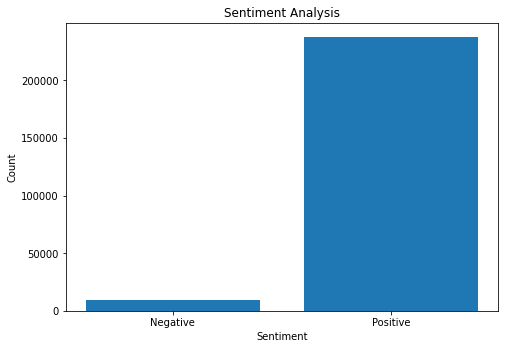

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['Negative', 'Positive'], [sentiment_count['negative'], sentiment_count['positive']])
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()